In [1]:
import scipy.io
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from keras import backend
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from matplotlib import pyplot
from keras.constraints import Constraint
import tensorflow as tf
 
    
    
def wasserstein_loss(y_true, y_pred):
	return tf.reduce_mean(tf.math.multiply(y_true, y_pred), axis=-1)



class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}


# define the discriminator model
def define_discriminator(label_shape, output_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=label_shape)
	# target image input
	in_target_image = Input(shape=output_shape)
	const = ClipConstraint(0.01)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	#patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], d)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=wasserstein_loss, optimizer=opt, loss_weights=[1])
	return model
 
# define an encoder block
def define_encoder_block(layer_in, n_filters, Stride = (2,2), batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (10,10), strides=Stride, padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = Dropout(0.5)(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, Stride = (2,2),dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (10,10), strides=Stride, padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	#g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

def decoder_block2(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	print(layer_in.shape)
	print(g.shape)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	print(g.shape)
	print(skip_in.shape)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	#g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator2(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, (1,2), batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	#e4 = define_encoder_block(e3, 512)
	#e5 = define_encoder_block(e4, 512)
	#e6 = define_encoder_block(e5, 512)
	#e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same',  kernel_initializer=init)(e3)
	print(b.shape)
	b = Activation('relu')(b)
	# decoder model
	#d1 = decoder_block(b, e7, 512)
	#d2 = decoder_block(d1, e6, 512)
	#d3 = decoder_block(d2, e5, 512)
	#d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(b, e3, 256)
	d6 = decoder_block(d5, e2, 128)
	d7 = decoder_block(d6, e1, 64)
	# output
	g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_layer = Activation('tanh')(g)
	out_layer = Flatten()(out_layer)
	out_layer = Dense(3200*9)(out_layer)
	out_layer = Dropout(0.5)(out_layer, training=True)
	out_layer = Reshape((40, 80,9))(out_layer)
	# define model
	model = Model(in_image, out_layer)
	return model

def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, (2,2), batchnorm=False)
	e2 = define_encoder_block(e1, 128, (2,2))
	e3 = define_encoder_block(e2, 256, (1,1))
	e4 = define_encoder_block(e2, 512, (1,1))
	e5 = define_encoder_block(e2, 512, (1,1))
	b = Conv2D(128, (4,4), strides=(1,1), padding='same',  kernel_initializer=init)(e5)
	d3 = decoder_block(b, e5, 512, (1,1))
	d4 = decoder_block(d3, e4, 512, (1,1), dropout=False)
	d5 = decoder_block(d4, e3, 256, (1,1))
	d6 = decoder_block(d5, e2, 128, (1,1))
	d7 = decoder_block(d6, e1, 64, (2,2))
	g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	# output
	# define model
	model = Model(in_image, g)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.00002, beta_1=0.5)
	model.compile(loss=[wasserstein_loss, 'mae'], optimizer=opt, loss_weights=[0.1, 1])
	return model
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 3, 5, 1))
	return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = -ones((len(X), 3, 5, 1))
	return X, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, testset, n_samples=3):
	# select a sample of input images

	valid_error = np.mean(np.abs(g_model.predict(testset[0])-testset[1]))
	train_error = np.mean(np.abs(g_model.predict(dataset[0])-dataset[1]))
	pred = g_model.predict(np.reshape(testset[0][445,:,:,:], (1,40,80,2)))
	pyplot.imshow(np.reshape(pred[:,:,:,0], (40,80)), vmin=-1, vmax=2)
	# save plot to file
	filename1 = 'plot2_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model2_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
	print('>Training Error: %.3f, Validation Error: %.3f' % (train_error, valid_error))
	return train_error, valid_error
 
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, testset, n_epochs=100, n_batch=1, n_critic=4):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	vr_hist=list()
	tr_hist=list()
	for i in range(n_steps):
		# select a batch of real samples
		for _ in range(n_critic):
			[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
			X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
			d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
			d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 2) == 1:
			tr, vr = summarize_performance(i, g_model, dataset, testset)
			vr_hist.append(vr)
			tr_hist.append(tr)
            
 
	return tr_hist, vr_hist

Using TensorFlow backend.


In [2]:
import h5py

In [3]:
datainput = h5py.File('realization30000.mat')
dataoutput = h5py.File('simul_obs25000.mat', 'r')
S = datainput['Sn_all'][5000:,:]
K = datainput['Y_all'][5000:,:]

simul_obs = dataoutput['simul_obs']

/home/darve/adncat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [4]:
K=np.array(K)
S=np.array(S)
simul_obs = np.array(simul_obs)

In [5]:
X_train = np.zeros((25000, 40, 80, 2))
X_train[:,:,:,0] = np.reshape(K, (25000, 40, 80))
X_train[:,:,:,1] = np.reshape(S, (25000, 40, 80))
Y_train = np.zeros((25000, 40, 80, 9))
for i in range(9):
    print(i)
    Y_train[:,:,:,i] = np.reshape(simul_obs[:,3792+i*3200:6992+i*3200], (25000, 40, 80))
Xmean = np.mean(X_train, axis=0)
Ymean = np.mean(Y_train, axis=0)
Xstd = np.std(X_train, axis=0)
Ystd = np.std(Y_train, axis=0)
print(np.std(Y_train, axis=0))
Y_train -= np.mean(Y_train, axis=0)
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)
Y_train /=np.std(Y_train, axis=0)

0
1
2
3
4
5
6
7
8
[[[8.38760710e-02 3.19326435e-01 7.74335176e-01 ... 5.05071458e-01
   7.53062900e-01 9.44223355e-01]
  [9.13738670e-02 3.08091545e-01 7.52095577e-01 ... 5.08639014e-01
   7.55642145e-01 9.50990415e-01]
  [9.64558735e-02 3.06281878e-01 7.37187677e-01 ... 5.12147133e-01
   7.59529299e-01 9.56138909e-01]
  ...
  [2.62753972e-01 5.23179186e-01 6.53958887e-01 ... 2.96885427e-01
   9.24276907e-01 7.89813875e-01]
  [2.63169727e-01 5.19647436e-01 6.49971155e-01 ... 2.95437756e-01
   9.19033458e-01 7.87727230e-01]
  [2.63516897e-01 5.16073297e-01 6.45772121e-01 ... 3.00295493e-01
   9.12988321e-01 7.86715498e-01]]

 [[9.44687141e-02 3.46782324e-01 8.32209280e-01 ... 5.11513518e-01
   7.73180196e-01 9.63949002e-01]
  [1.03885327e-01 3.29779511e-01 8.03644443e-01 ... 5.14957845e-01
   7.74372945e-01 9.69603647e-01]
  [1.09039744e-01 3.25197910e-01 7.83405823e-01 ... 5.18451566e-01
   7.78022453e-01 9.74359873e-01]
  ...
  [2.70801766e-01 5.29738418e-01 6.65602666e-01 ... 3.15680

In [8]:
dataset = [X_train[:5000,:,:,:], Y_train[:5000,:,:,:]]
dataset[0] += np.random.normal(0,0.1, size=dataset[0].shape)
dataset[1] += np.random.normal(0,0.1, size=dataset[1].shape)

In [9]:
testset = [X_train[5000:7000,:,:,:], Y_train[5000:7000,:,:,:]]

In [6]:
tt2 = define_generator((40,80,2))
data = np.reshape(Y_train[:,:,:,0], (25000, 40, 80, 1))
opt = Adam(lr=0.0002, beta_1=0.5)
tt2.compile(loss='mae', optimizer=opt, metrics=['mae'])
history = tt2.fit(X_train, data, batch_size=32, epochs=4, validation_split=0.8)
opt = Adam(lr=0.00002, beta_1=0.5)
tt2.compile(loss='mae', optimizer=opt, metrics=['mae'])
history = tt2.fit(X_train, data, batch_size=32, epochs=2, validation_split=0.8)

Train on 4999 samples, validate on 20001 samples
Epoch 1/4
4999/4999 [==============================] - 243s 49ms/step - loss: 0.3756 - mae: 0.3756 - val_loss: 0.3074 - val_mae: 0.3074
Epoch 2/4
4999/4999 [==============================] - 229s 46ms/step - loss: 0.2602 - mae: 0.2602 - val_loss: 0.2668 - val_mae: 0.2668
Epoch 3/4
4999/4999 [==============================] - 228s 46ms/step - loss: 0.2304 - mae: 0.2304 - val_loss: 0.2681 - val_mae: 0.2681
Epoch 4/4
4999/4999 [==============================] - 230s 46ms/step - loss: 0.2108 - mae: 0.2108 - val_loss: 0.2085 - val_mae: 0.2085
Train on 4999 samples, validate on 20001 samples
Epoch 1/2
4999/4999 [==============================] - 230s 46ms/step - loss: 0.1881 - mae: 0.1881 - val_loss: 0.1876 - val_mae: 0.1876
Epoch 2/2
4999/4999 [==============================] - 231s 46ms/step - loss: 0.1871 - mae: 0.1871 - val_loss: 0.1855 - val_mae: 0.1855


In [ ]:
# #tf.debugging.set_log_device_placement(True)
# image_shape = dataset[0].shape[1:]
# output_shape = dataset[1].shape[1:]
# print(output_shape)
# # define the models
# d_model = define_discriminator(image_shape, output_shape)
# d_model.summary()
# g_model = define_generator(image_shape)
# #g_model.load_weights('model_018751.h5')
# # define the composite model
# g_model.summary()
# gan_model = define_gan(g_model, d_model, image_shape)
# # train model
# tr1, vr1=train(d_model, g_model, gan_model, dataset, testset, n_epochs=100, n_batch=32, n_critic=4)

In [8]:
import matplotlib.pyplot as plt

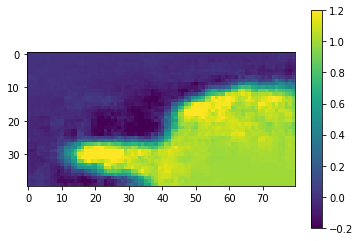

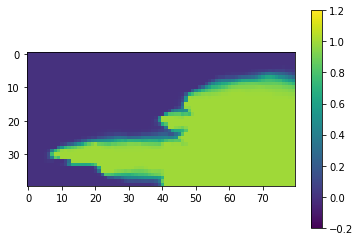

0.09514807753588862


In [15]:
ind = np.random.randint(5000,25000)
#ind = np.random.randint(0,4000)
#ind=4698
num =0
num_sample = 1
data_in = np.zeros((num_sample, 40, 80, 2))
data_in[:,:,:,:] = np.reshape(X_train[ind,:,:,:], (1,40,80,2))
data_out =tt2.predict(data_in)
pred = np.mean(data_out, axis=0)
pred *= np.reshape(Ystd[:,:,0], (40,80,1))
pred += np.reshape(Ymean[:,:,0], (40,80,1))
#pred = pred * np.std(Y_train2, axis=0) + np.mean(Y_train2, axis=0)
plt.imshow((np.reshape(pred, (40,80))), vmin=-0.2, vmax=1.2)
plt.colorbar()
plt.show()

plt.figure()
gt = np.reshape(Y_train[ind,:,:,0], (40,80,1))
gt *= np.reshape(Ystd[:,:,0], (40,80,1))
gt += np.reshape(Ymean[:,:,0], (40,80,1))
plt.imshow((np.reshape(gt, (40,80))), vmin=-0.2, vmax=1.2)
plt.colorbar()
plt.show()
print(np.mean(np.abs(gt-pred)**1))

